In [1]:
#!/usr/bin/python3
from sklearn.svm import OneClassSVM
import pandas as pd
import feather
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import pickle
np.random.seed(500)
import time
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold

In [3]:
pickle_in = open("df_yelpzip.pickle","rb")
df = pickle.load(pickle_in)
# df = pd.read_table("Data/YelpChi/output_review_yelpHotelData_NRYRcleaned.txt",header=None)
# df2 = pd.read_table("Data/YelpChi/output_meta_yelpHotelData_NRYRcleaned.txt",header=None, sep=" ")
# df['label'] =  df2[4]
# df['label'] = df['label'].replace(['N'],1)
# df['label'] = df['label'].replace(['Y'],-1)
# df.columns = ['review_content', 'label']

In [4]:
df

,user_id,prod_id,date,rating,label,review_content,word_count,tokenized,text_final
0,5044,0,2014-11-16,1.0,-1,"drinks were bad, the hot chocolate was watered...",36,"[drinks, were, bad, ,, the, hot, chocolate, wa...","['drink', 'bad', 'hot', 'chocolate', 'water', ..."
1,5045,0,2014-09-08,1.0,-1,this was the worst experience i've ever had a ...,260,"[this, was, the, worst, experience, i, 've, ev...","['bad', 'experience', 'ever', 'casual', 'fare'..."
2,5046,0,2013-10-06,3.0,-1,this is located on the site of the old spruce ...,50,"[this, is, located, on, the, site, of, the, ol...","['locate', 'site', 'old', 'spruce', 'video', '..."
3,5046,376,2013-11-02,3.0,-1,i am becoming frustrated with yelp. i placed ...,62,"[i, am, becoming, frustrated, with, yelp, ., i...","['become', 'frustrate', 'yelp', 'place', 'revi..."
4,5047,0,2014-11-30,5.0,-1,i enjoyed coffee and breakfast twice at toast ...,234,"[i, enjoyed, coffee, and, breakfast, twice, at...","['enjoy', 'coffee', 'breakfast', 'twice', 'toa..."
...,...,...,...,...,...,...,...,...,...
304335,265232,5041,2014-12-13,5.0,-1,great local bar with a cozy atmosphere (firepl...,38,"[great, local, bar, with, a, cozy, atmosphere,...","['great', 'local', 'bar', 'cozy', 'atmosphere'..."
304336,265233,5041,2014-12-11,5.0,-1,this cozy brooklyn restaurant is for sure a wi...,90,"[this, cozy, brooklyn, restaurant, is, for, su...","['cozy', 'brooklyn', 'restaurant', 'sure', 'wi..."
304337,265234,5041,2014-12-02,5.0,-1,i wanna let you in on one of brooklyn's best k...,229,"[i, wan, na, let, you, in, on, one, of, brookl...","['wan', 'na', 'let', 'one', 'brooklyn', 'best'..."
304338,265235,5041,2014-10-30,5.0,-1,bijans is the best!!! i love it here. first le...,20735,"[bijans, is, the, best, !, !, !, i, love, it, ...","['bijans', 'best', 'love', 'first', 'let', 'sa..."


In [5]:
pos=0 
neg = 0

for x in df['label']:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  40832  positive: 263508 total 304340 percent deceptive 13.416573569034632


In [6]:
#file_path = '/home/parallels/KTH/II2202/Data/YelpNYC/database_feather.feather'
#df = pd.read_feather(file_path, columns=None, use_threads=True)

In [7]:
df.dtypes

user_id             int32
prod_id             int32
date               object
rating            float64
label               int32
review_content     object
word_count          int32
tokenized          object
text_final         object
dtype: object

In [8]:
df.describe()

,user_id,prod_id,rating,label,word_count
count,304340.000000,304340.000000,304340.000000,304340.000000,304340.000000
mean,90112.485523,2612.333233,3.924371,0.731669,240.906135
std,74262.444989,1456.788655,1.145761,0.681662,2862.792327
min,5044.000000,0.000000,1.000000,-1.000000,1.000000
25%,25276.000000,1398.000000,3.000000,1.000000,45.000000
50%,67841.500000,2711.000000,4.000000,1.000000,87.000000
75%,143742.000000,3846.000000,5.000000,1.000000,155.000000
max,265320.000000,5043.000000,5.000000,1.000000,267753.000000


In [9]:
# # Step - a : Remove blank rows if any.
# df['review_content'].dropna(inplace=True)

In [10]:
# # Step - b : Change all the text to lower case
# df['review_content'] = [entry.lower() for entry in df['review_content']]

In [11]:
# # Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
# # tokenized = []
# # for index,entry in enumerate(genuine['review_content']): 
# #     genuine.loc[index,'tokenized'] = [word_tokenize(entry)]
# #     percent = index/len(genuine)*100
# #     print('percent done [%d%%]\r'%percent, end="")
# df['tokenized']= [word_tokenize(entry) for entry in df['review_content']]

In [12]:
# # Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
# tag_map = defaultdict(lambda : wn.NOUN)
# tag_map['J'] = wn.ADJ
# tag_map['V'] = wn.VERB
# tag_map['R'] = wn.ADV
# final_text = [None]*len(df['tokenized'])
# for index,entry in enumerate(df['tokenized']):
#     # Declaring Empty List to store the words that follow the rules for this step
#     Final_words = []
#     # Initializing WordNetLemmatizer()
#     percent = float(index/len(df['tokenized'])*100)

#     print('percent done [%f%%]\r'%percent, end="")
#     word_Lemmatized = WordNetLemmatizer()
#     # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
#     for word, tag in pos_tag(entry):
#         # Below condition is to check for Stop words and consider only alphabets
#         if word not in stopwords.words('english') and word.isalpha():
#             word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
#             Final_words.append(word_Final)
#     # The final processed set of words for each iteration will be stored in 'text_final'
#     df.loc[index,'text_final'] = str(Final_words)
#     final_text[index]=(Final_words)
    


In [13]:
# #to save the preporcessed list

# pickle_out = open("df_lemma_yelp_chicago.pickle","wb")
# pickle.dump(df, pickle_out)
# pickle_out.close()

In [14]:
x = df['text_final'].values.reshape(-1,1)
y = df['label'].values.reshape(-1,1)
y.shape

(304340, 1)

In [15]:
#undersample = RandomUnderSampler(sampling_strategy='majority')
undersample = RandomUnderSampler(sampling_strategy='majority')
#oversample = RandomOverSampler(sampling_strategy='minority')
X_under, y_under = undersample.fit_resample(x, y)
#X_over, y_over = oversample.fit_resample(X, df['label'])

In [16]:
d = {'text_final':X_under[:,0],'label':y_under[:,]}
dfu = pd.DataFrame(d)

In [17]:
dfu

,text_final,label
0,"['drink', 'bad', 'hot', 'chocolate', 'water', ...",-1
1,"['bad', 'experience', 'ever', 'casual', 'fare'...",-1
2,"['locate', 'site', 'old', 'spruce', 'video', '...",-1
3,"['become', 'frustrate', 'yelp', 'place', 'revi...",-1
4,"['enjoy', 'coffee', 'breakfast', 'twice', 'toa...",-1
...,...,...
81659,"['randomly', 'find', 'mike', 'fusion', 'medite...",1
81660,"['come', 'lunch', 'one', 'day', 'u', 'margarit...",1
81661,"['fly', 'lga', 'numerous', 'time', 'month', 'p...",1
81662,"['place', 'okay', 'sf', 'native', 'definitely'...",1


In [18]:
pos=0 
neg = 0
for x in dfu['label']:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  40832  positive: 40832 total 81664 percent deceptive 50.0


In [19]:
Train_X_oc_all, Test_X_oc_all = model_selection.train_test_split(dfu[['label','text_final']],test_size=0.3)

In [20]:
# check test genuine/deceptive
pos=0 
neg = 0

for x in Test_X_oc_all['label']:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  12246  positive: 12254 total 24500 percent deceptive 49.98367346938775


In [21]:
# split using genuine
Train_X, Test_X = model_selection.train_test_split((Train_X_oc_all.loc[(dfu['label'] == 1)]).text_final,test_size=0.3)


In [22]:
#split using deceptive
Train_X_dec, Test_X_dec = model_selection.train_test_split((Train_X_oc_all.loc[(dfu['label'] == -1)]).text_final,test_size=0.3)

In [23]:
Tfidf_vect = TfidfVectorizer(max_features=400)        
Tfidf_vect.fit(df['text_final'])

TfidfVectorizer(max_features=400)

In [24]:
#vectorizing genuine data
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [25]:
# vectorizing deceptive data
Train_X_Tfidf_dec = Tfidf_vect.transform(Train_X_dec)
Test_X_Tfidf_dec = Tfidf_vect.transform(Test_X_oc_all['text_final'])

In [26]:
# vectorizing all data
Test_X_Tfidf_all = Tfidf_vect.transform(df['text_final'])

In [27]:
Train_X_Tfidf

<20004x400 sparse matrix of type '<class 'numpy.float64'>'
	with 597945 stored elements in Compressed Sparse Row format>

In [28]:
# fit the training dataset on the classifier using [deceptive]
start_time = time.time()

clf_dec = OneClassSVM(gamma='auto', kernel='rbf', degree=5).fit(Train_X_Tfidf_dec)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# predict the labels on validation dataset

elapsed_time 161.47006368637085


In [29]:
# predict using deceptive
start_time = time.time()
predictions_oneclass_dec = clf_dec.predict(Test_X_Tfidf_dec)
#print(predictions_oneclass_dec)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# Use accuracy_score function to get the accuracy

elapsed_time 102.3124132156372


In [30]:
# deceptive predict count
pos=0 
neg = 0

for x in predictions_oneclass_dec:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos)       

negative:  11633  positive: 12867


In [31]:
cf_matrix=confusion_matrix(Test_X_oc_all['label'], predictions_oneclass_dec*-1)
metrics_result = precision_recall_fscore_support(Test_X_oc_all['label'], predictions_oneclass_dec*-1, average='weighted',zero_division=0)
print("Accuracy Score -> ",accuracy_score(predictions_oneclass_dec*-1, Test_X_oc_all['label'], normalize=True))
print("percision: ", metrics_result[0], ' recall: ' , metrics_result[1], ' fscore: ', metrics_result[2])
#print(metrics.f1_score(Test_X_oc_all['label'], predictions_oneclass_dec*-1, average='weighted'))
#sns.heatmap(cf_matrix, annot=True)

Accuracy Score ->  0.4731836734693878
percision:  0.473123326369335  recall:  0.4731836734693878  fscore:  0.47284936214026957


<AxesSubplot:>

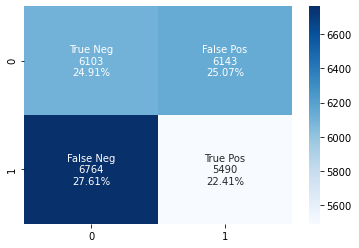

In [32]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


In [33]:
# fit the training dataset on the classifier using [genuine]
start_time = time.time()

clf_gen = OneClassSVM(gamma='auto', kernel='poly', degree=5).fit(Train_X_Tfidf)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# predict the labels on validation dataset

elapsed_time 98.18463563919067


In [34]:
# predict using [genuine]
start_time = time.time()
predictions_oneclass_gen = clf_gen.predict(Test_X_Tfidf_dec)
#print(predictions_oneclass_gen)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# Use accuracy_score function to get the accuracy

elapsed_time 114.01450991630554


In [35]:
# count of prediction using [genuine]
pos=0 
neg = 0

for x in predictions_oneclass_gen:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos)   

negative:  24436  positive: 64


In [36]:
print("Accuracy Score -> ",accuracy_score(predictions_oneclass_gen, Test_X_oc_all['label'], normalize=True))

Accuracy Score ->  0.49942857142857144


In [37]:
# # to save the classifier model

# pickle_out = open("clf_oneclass.pickle","wb")
# pickle.dump(clf, pickle_out)
# pickle_out.close()

In [38]:
X_train_all, X_validation_all, Y_train_all, Y_validation_all = train_test_split(Tfidf_vect.transform(dfu['text_final']), dfu['label'], test_size=0.30, random_state=1,stratify=dfu['label'] )

In [39]:
print(len(dfu['text_final']),len(Y_train_all))

81664 57164


In [40]:
pos=0 
neg = 0
for x in Y_train_all:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  28582  positive: 28582 total 57164 percent deceptive 50.0


In [41]:
# classifier checker

# your code
models = []
#models.append(['Logistic Regression', LogisticRegression(solver='liblinear', multi_class='ovr'),[],0,0])
#models.append(['Linear Discriminant Analysis', LinearDiscriminantAnalysis(),[],0,0])
#models.append(['K Nearest Neighbor', KNeighborsClassifier(),[],0,0])
#models.append(['Decesion Tree Classifier', DecisionTreeClassifier(),[],0,0])
#models.append(['Gaussien Naive Bayes', GaussianNB(),[],0,0])
models.append(['Support Vector Machine', SVC(gamma='auto',kernel='rbf'),[],0,0])
models.append(['Support Vector Machine', SVC(gamma='auto',kernel='poly'),[],0,0])
models.append(['Support Vector Machine', SVC(gamma='auto',kernel='linear'),[],0,0])
#models.append(['Random Forest', RandomForestClassifier(max_depth = 1000,random_state=1),[],0,0])

models = np.array(models,dtype=object)

for i in range(len(models)):
    start_time = time.time()
    #kfold = StratifiedKFold(n_splits=1, random_state=1, shuffle=True)
    cv_results = cross_val_score(models[i,1], X_train_all, Y_train_all, scoring='accuracy')
    models[i,2] = cv_results
    models[i,3] = cv_results.mean()
    models[i,4] = cv_results.std()
    elapsed_time = time.time() - start_time
    print('%s: %f (%f) elapsed time: %f' % (models[i,0], models[i,3], models[i,4],elapsed_time))
    
    

best_model= models[np.argmax(models[:,3]),:]
print("the best model performer is: ", best_model[0])

Support Vector Machine: 0.645126 (0.002907) elapsed time: 5948.096231
Support Vector Machine: 0.501819 (0.003726) elapsed time: 5875.056019
Support Vector Machine: 0.654363 (0.003920) elapsed time: 5522.685506
the best model performer is:  Support Vector Machine


In [42]:
clf_model=SVC(gamma='auto',kernel='linear',degree=2).fit(X_train_all, Y_train_all)

In [43]:
result=clf_model.predict(X_validation_all)

In [44]:
pos=0 
neg = 0
for x in result:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  13126  positive: 11374 total 24500 percent deceptive 53.57551020408163


In [45]:
print("Accuracy Score -> ",accuracy_score(result, Y_validation_all, normalize=True))
metrics_result = precision_recall_fscore_support(Y_validation_all, result, average='binary',zero_division=0)
print("percision: ", metrics_result[0], ' recall: ' , metrics_result[1], ' fscore: ', metrics_result[2], '\n') 

Accuracy Score ->  0.6508571428571429
percision:  0.6624758220502901  recall:  0.6151020408163266  fscore:  0.6379105993904504 



In [46]:
df2= df[['text_final','label']]

In [47]:
df3= pd.concat([df2, dfu]).drop_duplicates(keep=False)

In [48]:
pos=0 
neg = 0
for x in df3['label']:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  0  positive: 221927 total 221927 percent deceptive 0.0


In [49]:
# split using genuine
perc=(1- len(Y_train_all)/len(df3))
Train_X_oneclass, Test_X_oneclass = model_selection.train_test_split((df3.loc[(df['label'] == 1)]).text_final,test_size=perc)

In [50]:
Train_X_oneclass.shape

(57164,)

In [51]:
# max_features = 100;
# while max_features < 5000:
#     Tfidf_vect = TfidfVectorizer(max_features=max_features)        
#     Tfidf_vect.fit(df['text_final'])
#     Train_X_Tfidf = Tfidf_vect.transform(Train_X)
#     Test_X_Tfidf = Tfidf_vect.transform(Test_X)
#     Train_X_Tfidf_dec = Tfidf_vect.transform(Train_X_dec)
#     Test_X_Tfidf_dec = Tfidf_vect.transform(Test_X_oc_all['text_final'])
#     one_class_train = Tfidf_vect.transform(Train_X_oneclass)
    
#     clf_result = OneClassSVM( kernel='poly', degree=2).fit(one_class_train)
#     predict_result = clf_result.predict(Test_X_Tfidf_dec)
#     acc = accuracy_score(predict_result*1, Test_X_oc_all['label'], normalize=True)
#     metrics_result = precision_recall_fscore_support(Test_X_oc_all['label'], predict_result*1, average='weighted',zero_division=0)
#     print('features used: ', max_features, ' accuracy: ', acc)
#     print("percision: ", metrics_result[0], ' recall: ' , metrics_result[1], ' fscore: ', metrics_result[2], '\n')  
    
#     max_features += 100

In [52]:
one_class_train = Tfidf_vect.transform(Train_X_oneclass)

In [53]:
one_class_train

<57164x400 sparse matrix of type '<class 'numpy.float64'>'
	with 1711950 stored elements in Compressed Sparse Row format>

In [54]:
# fit the training dataset on the classifier
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = [0,1,2,3]
classifiers = []
for kern in kernels:
    start_time = time.time()
    if kern == 'poly':
        for deg in degrees:
            start_time = time.time()
            clf_result = OneClassSVM( kernel=kern, degree=deg).fit(one_class_train)
            elapsed_time = time.time() - start_time
            classifiers.append([kern,deg,clf_result,elapsed_time])
            print('kernel used: ' , kern, ' degree used: ' , deg, ' elapsed_time:' , elapsed_time)
            
    else:
        clf_result = OneClassSVM(gamma='auto', kernel=kern).fit(Train_X_Tfidf_dec)
        elapsed_time = time.time() - start_time
        classifiers.append([kern,0,clf_result,elapsed_time])
        print('kernel used: ' , kern, ' elapsed_time: ' , elapsed_time)

# predict the labels on validation dataset

kernel used:  linear  elapsed_time:  188.7208707332611
kernel used:  poly  degree used:  0  elapsed_time: 809.2828857898712
kernel used:  poly  degree used:  1  elapsed_time: 1700.7988476753235
kernel used:  poly  degree used:  2  elapsed_time: 1633.032748222351
kernel used:  poly  degree used:  3  elapsed_time: 1681.8638503551483
kernel used:  rbf  elapsed_time:  179.0544719696045
kernel used:  sigmoid  elapsed_time:  175.29248666763306


In [55]:
clas_result = []
for clas in classifiers:
    start_time = time.time()
    predict_result = clas[2].predict(Test_X_Tfidf_dec)
    elapsed_time = time.time() - start_time
    clas_result.append([clas[0],clas[1],clas[2],predict_result])
    acc = accuracy_score(predict_result*1, Test_X_oc_all['label'], normalize=True)
    metrics_result = precision_recall_fscore_support(Test_X_oc_all['label'], predict_result*1, average='binary',zero_division=0)
    print('kernel used: ' , clas[0], ' degree used:' , clas[1], ' elapsed_time: ' , elapsed_time, ' accuracy: ', acc)
    print("percision: ", metrics_result[0], ' recall: ' , metrics_result[1], ' fscore: ', metrics_result[2], '\n')  
# predict the labels on validation dataset

kernel used:  linear  degree used: 0  elapsed_time:  94.40813684463501  accuracy:  0.5282448979591837
percision:  0.5270186335403727  recall:  0.5539415700995594  fscore:  0.5401448237447282 

kernel used:  poly  degree used: 0  elapsed_time:  304.2993071079254  accuracy:  0.49983673469387757
percision:  0.0  recall:  0.0  fscore:  0.0 

kernel used:  poly  degree used: 1  elapsed_time:  315.7951731681824  accuracy:  0.5562448979591836
percision:  0.5630014587892049  recall:  0.5039170882976987  fscore:  0.5318232710360864 

kernel used:  poly  degree used: 2  elapsed_time:  320.8666365146637  accuracy:  0.5439591836734694
percision:  0.5486717694732103  recall:  0.49722539578913005  fscore:  0.5216832912367824 

kernel used:  poly  degree used: 3  elapsed_time:  328.4551544189453  accuracy:  0.5343265306122449
percision:  0.538370720188902  recall:  0.48376040476579074  fscore:  0.5096067053513861 

kernel used:  rbf  degree used: 0  elapsed_time:  106.19413089752197  accuracy:  0.526

<AxesSubplot:>

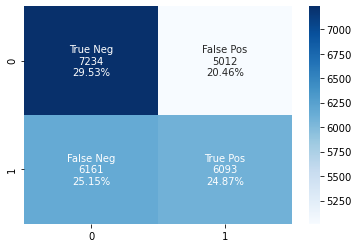

In [56]:
clf_result = OneClassSVM( kernel='poly', degree=2).fit(one_class_train)
predict_result = clf_result.predict(Test_X_Tfidf_dec)

cf_matrix=confusion_matrix(Test_X_oc_all['label'], predict_result*1)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
